# Preprocessing OASIS1

In [1]:
# IMPORTS
# DATA MANIPULATION
import pandas as pd
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import set_config; set_config(display='diagram') # Visualize pipelines in HTML
import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree

# MACHINE LEARNING
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb

/home/cynthias13w/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Importing Data
oasis1_cs_path = '../raw_data/OASIS1/oasis_cross-sectional.csv'
oasis1 = pd.read_csv(oasis1_cs_path)

In [3]:
# Checking shape
oasis1.shape

(436, 12)

📜 <big> Note: </big>


* **`CDR`**  Clinical Dementia Rating 
    * 0= nondemented;
    * 0.5 – very mild dementia;
    * 1 = mild dementia;
    * 2 = moderate dementia

* **`eTIV`** Estimated total intracranial volume (eTIV)

* **`nWBV`** Normalized whole brain volume

* **`ASF`** Atlas scaling factor

In [4]:
oasis1.sample(20)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
391,OAS1_0432_MR1,F,R,72,2.0,4.0,26.0,0.5,1453,0.773,1.208,NaN
65,OAS1_0070_MR1,F,R,63,3.0,2.0,30.0,0.0,1327,0.801,1.323,NaN
98,OAS1_0106_MR1,F,R,81,2.0,4.0,30.0,0.0,1230,0.717,1.427,NaN
299,OAS1_0331_MR1,F,R,54,NaN,NaN,NaN,NaN,1467,0.821,1.196,NaN
153,OAS1_0165_MR1,F,R,74,2.0,3.0,29.0,0.0,1395,0.787,1.258,NaN
417,OAS1_0080_MR2,F,R,25,NaN,NaN,NaN,NaN,1605,0.841,1.093,20.0
125,OAS1_0135_MR1,M,R,64,2.0,4.0,29.0,0.0,1561,0.801,1.124,NaN
380,OAS1_0420_MR1,F,R,22,NaN,NaN,NaN,NaN,1732,0.848,1.013,NaN
10,OAS1_0012_MR1,M,R,30,NaN,NaN,NaN,NaN,1574,0.842,1.115,NaN
219,OAS1_0240_MR1,F,R,74,2.0,NaN,26.0,0.5,1171,0.736,1.499,NaN


In [5]:
oasis1.isnull().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

## Data Cleaning

**We want to define a function that:**

1. Drops rows that have no values for CDR (prediction)
2. Fills empty values for socioeconomic status with a value
3. Replaces Male with 1 and Female with 0
4. Converts CDR from 4 unique values to 2 unique values so that we now have a binary classification problem
5. Drops columns Delay and Handedness

In [6]:
def clean_data(df):
    """This function removes CDR rows containing NANs, 
    fills SES missing values with status 3,
    and drops columns ID, Delay and Hand."""
    
    # Imputing with the median value 
    df['SES'].fillna(value=3, inplace=True) 
    
    # DROPPING ROWS WITHOUT TARGET
    df.dropna(subset = ["CDR"], inplace = True)
    
    
    # TARGET
    df["CDR"] = df["CDR"].map({0:0, 
                               0.5:1, 
                               1:1, 
                               2:1})
    
    # DROPPING USELESS FEATURES
    df.drop(['Delay', 'Hand', 'ID'], inplace = True, axis=1)

    return df.reset_index(drop = True)

In [7]:
oasis1 = clean_data(oasis1)
oasis1

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,1,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...
230,F,70,1.0,4.0,29.0,1,1295,0.748,1.355
231,F,73,3.0,2.0,23.0,1,1536,0.730,1.142
232,F,61,2.0,4.0,28.0,0,1354,0.825,1.297
233,M,61,5.0,2.0,30.0,0,1637,0.780,1.072


### Testing my code

In [8]:
# Check shape again
oasis1.shape

(235, 9)

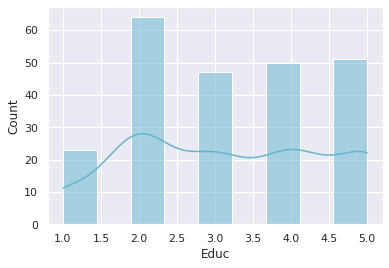

In [9]:
# Education is not normally distrbuted
sns.histplot(oasis1.Educ,kde = True, color = 'c');

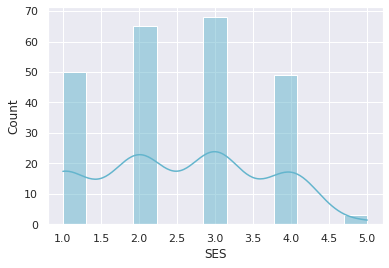

In [10]:
sns.histplot(oasis1.SES, kde = True, color = 'c');

In [11]:
# Check whether NANs are still here
oasis1.CDR.unique()

array([0, 1])

In [12]:
# Check SES column
oasis1.SES.unique()

array([3., 1., 2., 4., 5.])

In [13]:
# Check M/F column
oasis1['M/F']

0      F
1      F
2      F
3      M
4      F
      ..
230    F
231    F
232    F
233    M
234    F
Name: M/F, Length: 235, dtype: object

## Defining variables

In [14]:
# Defining variables
X = oasis1.drop(columns = ['CDR'])
y = oasis1['CDR']

In [15]:
X

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
0,F,74,2.0,3.0,29.0,1344,0.743,1.306
1,F,55,4.0,1.0,29.0,1147,0.810,1.531
2,F,73,4.0,3.0,27.0,1454,0.708,1.207
3,M,74,5.0,2.0,30.0,1636,0.689,1.073
4,F,52,3.0,2.0,30.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...
230,F,70,1.0,4.0,29.0,1295,0.748,1.355
231,F,73,3.0,2.0,23.0,1536,0.730,1.142
232,F,61,2.0,4.0,28.0,1354,0.825,1.297
233,M,61,5.0,2.0,30.0,1637,0.780,1.072


In [16]:
# Holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

In [17]:
X_train

,M/F,Age,Educ,SES,MMSE,eTIV,nWBV,ASF
126,M,70,5.0,1.0,30.0,1660,0.739,1.057
79,F,84,2.0,2.0,27.0,1390,0.727,1.263
5,F,81,5.0,2.0,30.0,1664,0.679,1.055
56,M,84,3.0,4.0,28.0,1483,0.697,1.183
120,F,74,5.0,2.0,30.0,1400,0.754,1.254
...,...,...,...,...,...,...,...,...
106,F,74,3.0,3.0,28.0,1614,0.697,1.087
14,F,58,5.0,1.0,30.0,1235,0.820,1.421
92,M,84,5.0,1.0,29.0,1707,0.731,1.028
179,M,86,1.0,4.0,15.0,1512,0.665,1.161


In [18]:
oasis1.isnull().sum()

M/F     0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

## Preprocessing pipeline

📜 Note: columns **nWBV and ASF** already normalized
 
 According to visualizations in file 'Demographic_visual.ipynb', we decided to scale as follows:
 
**Columns to scale:**

Standard Scale: age

Robust Scale: eTIV, MMSE

MinMax Scale: Educ

In [19]:
standard_features = ['Age']
robust_features = ['eTIV', 'MMSE']
minmax_features = ['Educ', 'SES']
nothing_to_scale = ['nWBV','ASF']
binary_categorical_features = ['M/F']

numerical_features = standard_features + robust_features + minmax_features + nothing_to_scale

In [20]:
class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [21]:
class ColumnNameExtractorAfterImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, *_):
        return self

    def transform(self, X, *_):
        return pd.DataFrame(X, columns=self.columns)

In [22]:
# Transformer for numerical features

def numerical_pipeline():
    """This function transforms all numerical features according to their respective scalers
    """
    
    # Simple Imputer
    # simple_imputer_frequent = SimpleImputer(strategy = "most_frequent")
    
    # Scalers
    standard_features = ['Age']
    robust_features = ['eTIV', 'MMSE']
    minmax_features = ['Educ', 'SES']
    nothing_to_scale = ['nWBV','ASF']
    
    features_in_this_order = standard_features + robust_features + minmax_features + nothing_to_scale
    
    numerical_transformer = CustomColumnTransformer([
        ('standard_scaler', StandardScaler(), standard_features),
        ('robust_scaler', RobustScaler(), robust_features),
        ('minmax_scaler', MinMaxScaler(), minmax_features),
         ], remainder = 'passthrough')
    
    
    # Pipeline
    numerical_pipeline = Pipeline([
        #("simple_imputer_most_frequent", simple_imputer_frequent),
        #("keeping_column_names", ColumnNameExtractorAfterImputer(features_in_this_order)),
        ("numerical_transformer", numerical_transformer)
    ])
    
    return numerical_pipeline

numerical_pipeline = numerical_pipeline()
numerical_pipeline

Pipeline(steps=[('numerical_transformer',
                 CustomColumnTransformer(remainder='passthrough',
                                         transformers=[('standard_scaler',
                                                        StandardScaler(),
                                                        ['Age']),
                                                       ('robust_scaler',
                                                        RobustScaler(),
                                                        ['eTIV', 'MMSE']),
                                                       ('minmax_scaler',
                                                        MinMaxScaler(),
                                                        ['Educ', 'SES'])]))])

In [23]:
# Transformer for categorical features

def binary_categorical_transformer():
    """This function encodes all categorical features according to their respective encoder.
    """
    categorical_transformer = CustomColumnTransformer([
       ("ohe_binary", 
         OneHotEncoder(sparse = False,
                       drop = "if_binary", 
                       handle_unknown = "error"), 
         binary_categorical_features)
    ])
    return categorical_transformer

binary_category_transformer = binary_categorical_transformer()
binary_category_transformer

CustomColumnTransformer(transformers=[('ohe_binary',
                                       OneHotEncoder(drop='if_binary',
                                                     sparse=False),
                                       ['M/F'])])

## Parellel Transformation: Numerical + Categorical

In [24]:
preprocessor = CustomColumnTransformer([
            ("num_transformer", numerical_pipeline, numerical_features ),
            ("cat_transformer", binary_category_transformer, binary_categorical_features)
            ])

preprocessor

CustomColumnTransformer(transformers=[('num_transformer',
                                       Pipeline(steps=[('numerical_transformer',
                                                        CustomColumnTransformer(remainder='passthrough',
                                                                                transformers=[('standard_scaler',
                                                                                               StandardScaler(),
                                                                                               ['Age']),
                                                                                              ('robust_scaler',
                                                                                               RobustScaler(),
                                                                                               ['eTIV',
                                                                                                'MMSE']),
                                                                                              ('minmax_scaler',
                                                                                               MinMaxScaler(),
                                                                                               ['Educ',
                                                                                                'SES'])]))]),
                                       ['Age', 'eTIV', 'MMSE', 'Educ', 'SES',
                                        'nWBV', 'ASF']),
                                      ('cat_transformer',
                                       CustomColumnTransformer(transformers=[('ohe_binary',
                                                                              OneHotEncoder(drop='if_binary',
                                                                                            sparse=False),
                                                                              ['M/F'])]),
                                       ['M/F'])])

In [25]:
X_train = preprocessor.fit_transform(X_train)
X_train

,num_transformer__standard_scaler__Age,num_transformer__robust_scaler__eTIV,num_transformer__robust_scaler__MMSE,num_transformer__minmax_scaler__Educ,num_transformer__minmax_scaler__SES,num_transformer__remainder__nWBV,num_transformer__remainder__ASF,cat_transformer__ohe_binary__M/F_M
0,-0.224264,1.082592,0.25,1.00,0.00,0.739,1.057,1.0
1,0.959437,-0.289708,-0.50,0.25,0.25,0.727,1.263,0.0
2,0.705787,1.102922,0.25,1.00,0.25,0.679,1.055,0.0
3,0.959437,0.182973,-0.25,0.50,0.75,0.697,1.183,1.0
4,0.113936,-0.238882,0.25,1.00,0.25,0.754,1.254,0.0
...,...,...,...,...,...,...,...,...
159,0.113936,0.848793,-0.25,0.50,0.50,0.697,1.087,0.0
160,-1.238865,-1.077510,0.25,1.00,0.00,0.820,1.421,0.0
161,0.959437,1.321474,0.00,1.00,0.00,0.731,1.028,1.0
162,1.128537,0.330368,-3.50,0.00,0.75,0.665,1.161,1.0


In [26]:
X_test = preprocessor.transform(X_test)
X_test

,num_transformer__standard_scaler__Age,num_transformer__robust_scaler__eTIV,num_transformer__robust_scaler__MMSE,num_transformer__minmax_scaler__Educ,num_transformer__minmax_scaler__SES,num_transformer__remainder__nWBV,num_transformer__remainder__ASF,cat_transformer__ohe_binary__M/F_M
0,-0.731564,0.579416,0.00,0.25,0.75,0.801,1.124,1.0
1,0.029386,0.091487,0.00,0.25,0.25,0.776,1.198,0.0
2,0.705787,-1.387548,-0.75,1.00,0.25,0.743,1.495,0.0
3,1.382187,0.452351,0.25,1.00,0.00,0.715,1.142,0.0
4,0.452137,-0.574333,0.00,0.50,0.25,0.773,1.316,0.0
...,...,...,...,...,...,...,...,...
66,0.705787,0.198221,-0.25,0.50,0.25,0.759,1.181,0.0
67,0.621237,0.238882,-2.25,0.25,0.75,0.665,1.175,1.0
68,0.790337,0.335451,-0.25,1.00,0.00,0.742,1.160,0.0
69,-0.055164,-0.625159,-3.50,0.50,0.50,0.668,1.325,0.0


In [27]:
# Length of y_test = 59
np.unique(y_test, return_counts = True)

# Length of X_test = 59
len(X_test)

71

In [28]:
# Making a copy of X_scaled
X_train_trial = X_train.copy()
X_train_trial

,num_transformer__standard_scaler__Age,num_transformer__robust_scaler__eTIV,num_transformer__robust_scaler__MMSE,num_transformer__minmax_scaler__Educ,num_transformer__minmax_scaler__SES,num_transformer__remainder__nWBV,num_transformer__remainder__ASF,cat_transformer__ohe_binary__M/F_M
0,-0.224264,1.082592,0.25,1.00,0.00,0.739,1.057,1.0
1,0.959437,-0.289708,-0.50,0.25,0.25,0.727,1.263,0.0
2,0.705787,1.102922,0.25,1.00,0.25,0.679,1.055,0.0
3,0.959437,0.182973,-0.25,0.50,0.75,0.697,1.183,1.0
4,0.113936,-0.238882,0.25,1.00,0.25,0.754,1.254,0.0
...,...,...,...,...,...,...,...,...
159,0.113936,0.848793,-0.25,0.50,0.50,0.697,1.087,0.0
160,-1.238865,-1.077510,0.25,1.00,0.00,0.820,1.421,0.0
161,0.959437,1.321474,0.00,1.00,0.00,0.731,1.028,1.0
162,1.128537,0.330368,-3.50,0.00,0.75,0.665,1.161,1.0


# 🎰SVC

## SVC Linear

### Just a trial

In [29]:
# Instantiating linear support vector classifier
model_svc = SVC(kernel = 'linear')

In [30]:
# Fitting LinearSVC
model_svc.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
# Prediction on X_test
y_pred_SVC = model_svc.predict(X_test)

In [32]:
cm_svc = confusion_matrix(y_test, y_pred_SVC)
cm_svc

array([[39,  3],
       [ 9, 20]])

In [33]:
baseline_recall_svc = recall_score(y_test, y_pred_SVC)
baseline_recall_svc

0.6896551724137931

###   🤖  Grid Searching

In [34]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(700,750,1),
              'gamma':[1,0.1,0.001,0.0001]}

# GridSearching
gridsearch_svc = GridSearchCV(model_svc, 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712,
       713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725,
       726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738,
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]),
                         'gamma': [1, 0.1, 0.001, 0.0001]},
             scoring='recall')

In [35]:
# Best estimator obtained from grid searching
best_linear_svc = gridsearch_svc.best_estimator_
best_linear_svc

SVC(C=700, gamma=1, kernel='linear')

### Best SVC linear

In [36]:
# Fitting the best estimator onto the train set
best_linear_svc.fit(X_train, y_train)

SVC(C=700, gamma=1, kernel='linear')

In [37]:
# Predicting X_test
best_svc_pred = best_linear_svc.predict(X_test)

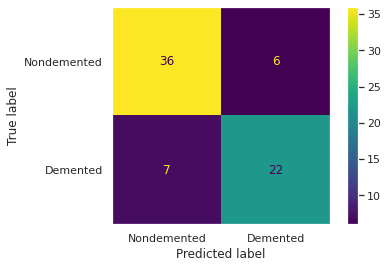

In [38]:
# Confusion matrix
cm_svc = confusion_matrix(y_test, best_svc_pred)
cm_svc

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                             display_labels=["Nondemented","Demented"])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [39]:
# Recall score
recall_score(y_test, best_svc_pred)

0.7586206896551724

## SVC Poly

###  🤖 Grid Searching

In [40]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(1,50,1),
              'gamma':[1,0.1,0.001,0.0001],
             'degree': np.arange(1,10,1)}

# GridSearching
gridsearch_svc = GridSearchCV(SVC(kernel = 'poly'), 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': [1, 0.1, 0.001, 0.0001]},
             scoring='recall')

In [41]:
# Best estimator obtained from grid searching
best_poly_svc = gridsearch_svc.best_estimator_
best_poly_svc

SVC(C=7, degree=2, gamma=1, kernel='poly')

### Best SVC Poly

In [42]:
# Predicting X_test
best_poly_pred = best_poly_svc.predict(X_test)

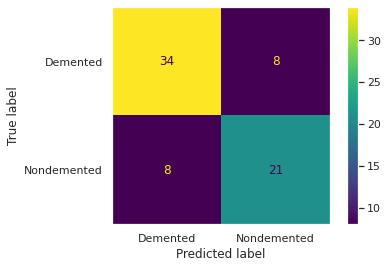

In [43]:
# Confusion matrix
cm_poly_svc = confusion_matrix(y_test, best_poly_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_poly_svc,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [44]:
# Recall score
recall_score(y_test, best_poly_pred)

0.7241379310344828

## SVC Rbf

### Grid Searching

In [45]:
# Creating a parameter grid: map the parameter names to the values that should be searched in a dictionary
param_grid = {'C':np.arange(1,200,1),
              'gamma':[1,0.1,0.001,0.0001]}

# GridSearching
gridsearch_svc = GridSearchCV(SVC(kernel = 'rbf'), 
                          param_grid, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  9...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199]),
                         'gamma': [1, 0.1, 0.001, 0.0001]},
             scoring='recall')

In [46]:
# Best estimator obtained from grid searching
best_rbf_svc = gridsearch_svc.best_estimator_
best_rbf_svc

SVC(C=128, gamma=0.1)

### Best SVC Rbf

In [47]:
# Predicting X_test
best_rbf_pred = best_rbf_svc.predict(X_test)

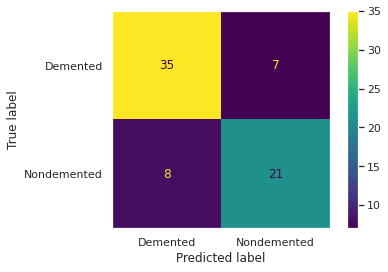

In [48]:
# Confusion matrix
cm_rbf_svc = confusion_matrix(y_test, best_rbf_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rbf_svc,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [49]:
# Recall score
recall_score(y_test, best_rbf_pred)

0.7241379310344828

#  🤹 K Neighbors Classifier

ELBOW METHOD

In [50]:
# Instantiating KNeighborsClassifier
neigh = KNeighborsClassifier()

###  🤖 Grid Searching

In [51]:
# Defining the parameter values that should be searched
k_range = list(range(1, 31))

# Creating a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

In [52]:
# Performing a grid search
grid = GridSearchCV(neigh, 
                    param_grid, 
                    cv=10, 
                    scoring='recall')

In [53]:
# Fitting grid on train set
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='recall')

In [54]:
best_neigh = grid.best_estimator_

### Best Neigh model

In [55]:
# Fitting KNeighborsClassifier
best_neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [56]:
best_neigh_pred = best_neigh.predict(X_test)

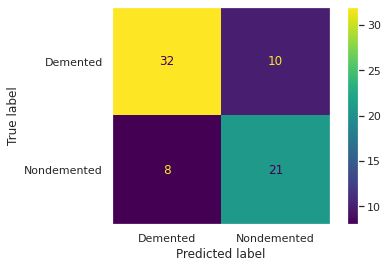

In [57]:
# Confusion matrix
cm_neigh = confusion_matrix(y_test, best_neigh_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_neigh,
                             display_labels=['Demented','Nondemented'])
disp.plot(cmap = 'viridis')
plt.grid(visible = None)
plt.show()

In [58]:
recall_score(y_test, best_neigh_pred)

0.7241379310344828

# Ensemble

## 🌳Decision Tree

### Trial (just to practice)

In [59]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([93, 71]))

In [60]:
# Instantiating Decision Tree
tree_clf = DecisionTreeClassifier(max_depth = 5)

In [61]:
# Fitting decision tree
tree_clf.fit(X_train_trial,y_train)

DecisionTreeClassifier(max_depth=5)

In [62]:
# Predicting X_test
prediction = tree_clf.predict(X_test)
prediction

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0])

In [63]:
# Accuracy
recall_score(y_test, prediction)

0.6896551724137931

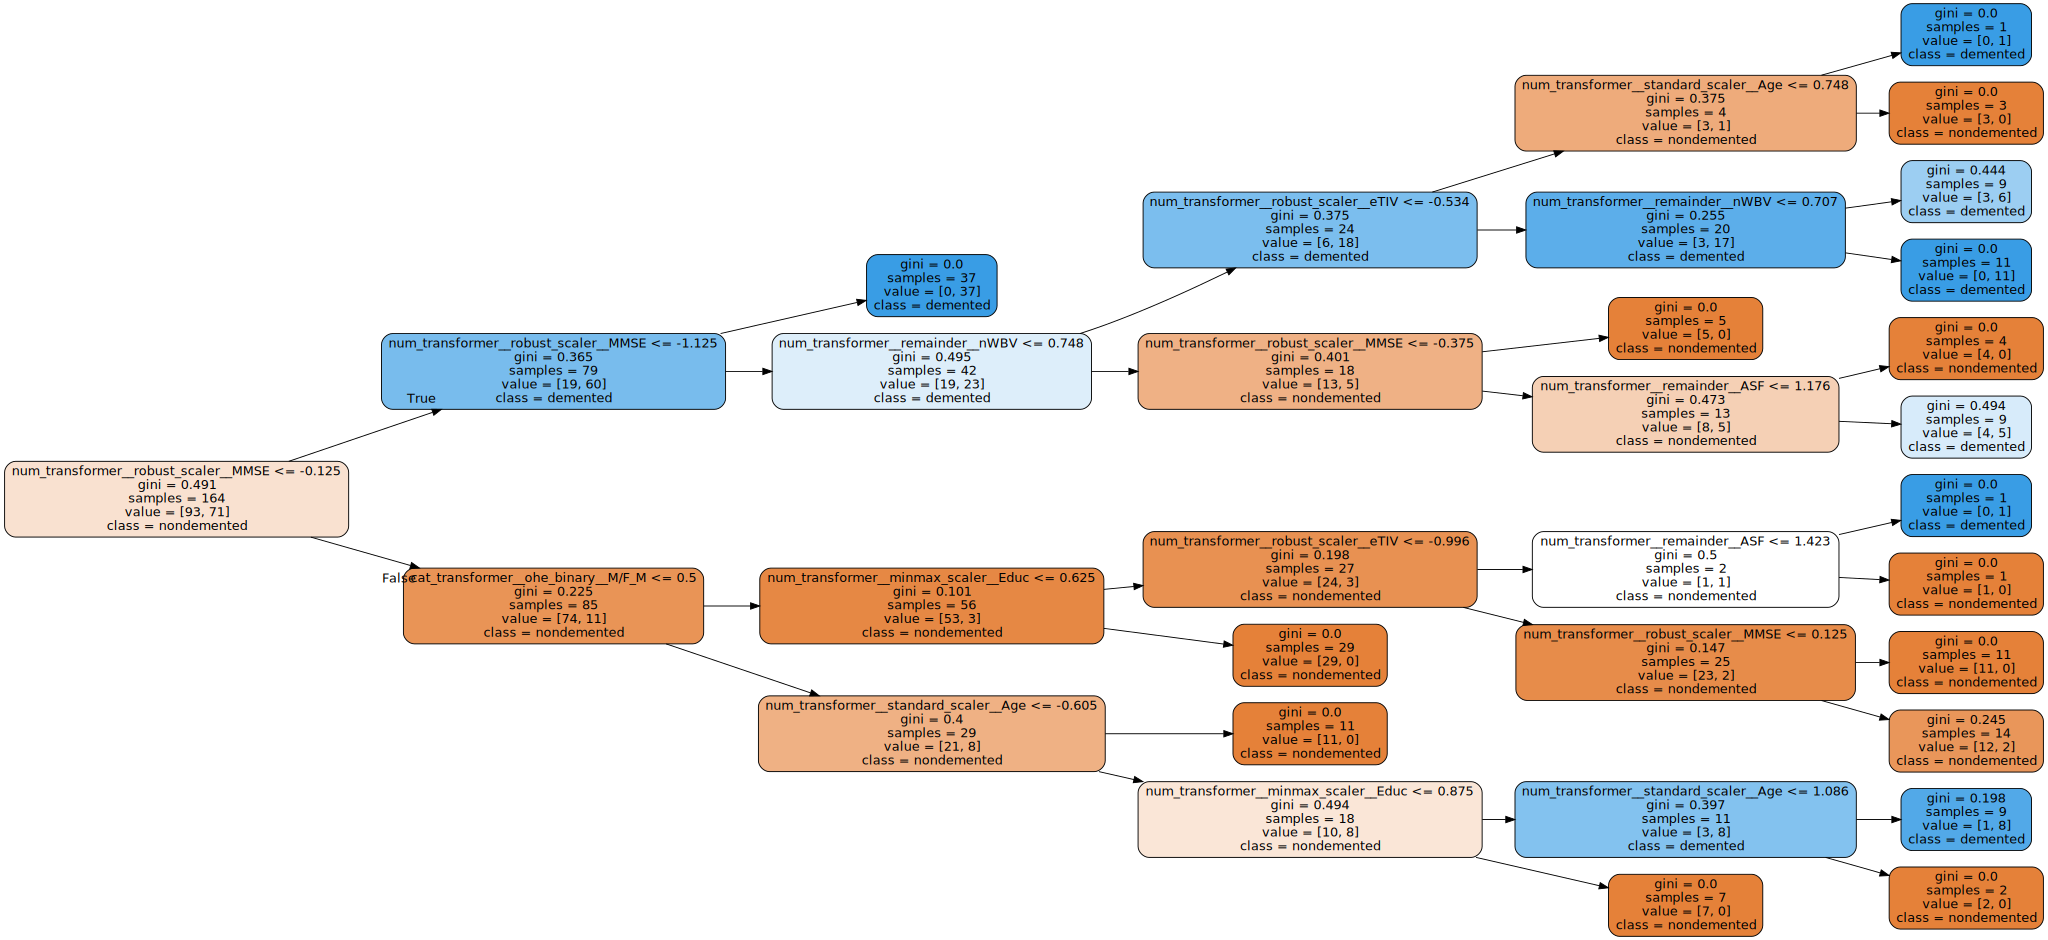

In [64]:
# Export model graph
export_graphviz(tree_clf, out_file="oasis1_tree.dot", 
                feature_names=X_train_trial.columns,
                class_names=['nondemented', 'demented'], 
                rounded=True,
                filled=True,
                rotate = True,
                fontname = 'futura')

# Import model graph
with open("oasis1_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### 🤖 Grid Searching 

In [65]:
# Parameters to grid search
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_split': range(2,10),
              'min_samples_leaf': range(2,10)
             #'max_features': range(0,len(X_train.columns),
              }

In [66]:
# GridSearching
gridsearch = GridSearchCV(DecisionTreeClassifier(), 
                          parameters, n_jobs = -1, 
                          scoring = 'recall', cv = 5)

# Fitting gridsearch on X and y
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             scoring='recall')

In [67]:
# Best score according to gridsearch
gridsearch.best_score_

0.8295238095238094

In [68]:
# Best parameters
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

### 🌲 Best Tree

In [69]:
# Instantiating best tree
best_tree = gridsearch.best_estimator_

# Fitting best tree
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=4)

In [70]:
# Predictions
y_pred = best_tree.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0])

In [71]:
# Recall score
recall_score(y_test, y_pred)

0.6206896551724138

In [72]:
# Predictions on the test set
y_tree_pred = best_tree.predict(X_test)
y_tree_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0])

In [73]:
# Confusion Matrix
tree_cm = confusion_matrix(y_test, y_tree_pred)

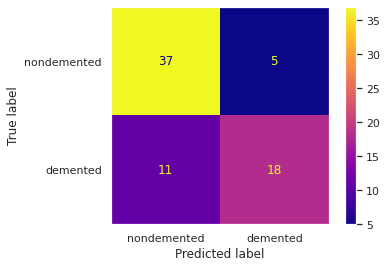

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm,
                             display_labels=["nondemented","demented"])
disp.plot(cmap = 'plasma')

plt.grid(visible = False)
plt.show()

In [75]:
y_train.value_counts()

0    93
1    71
Name: CDR, dtype: int64

In [76]:
y_test.value_counts()
# We want to capture all 23 people with dementia

0    42
1    29
Name: CDR, dtype: int64

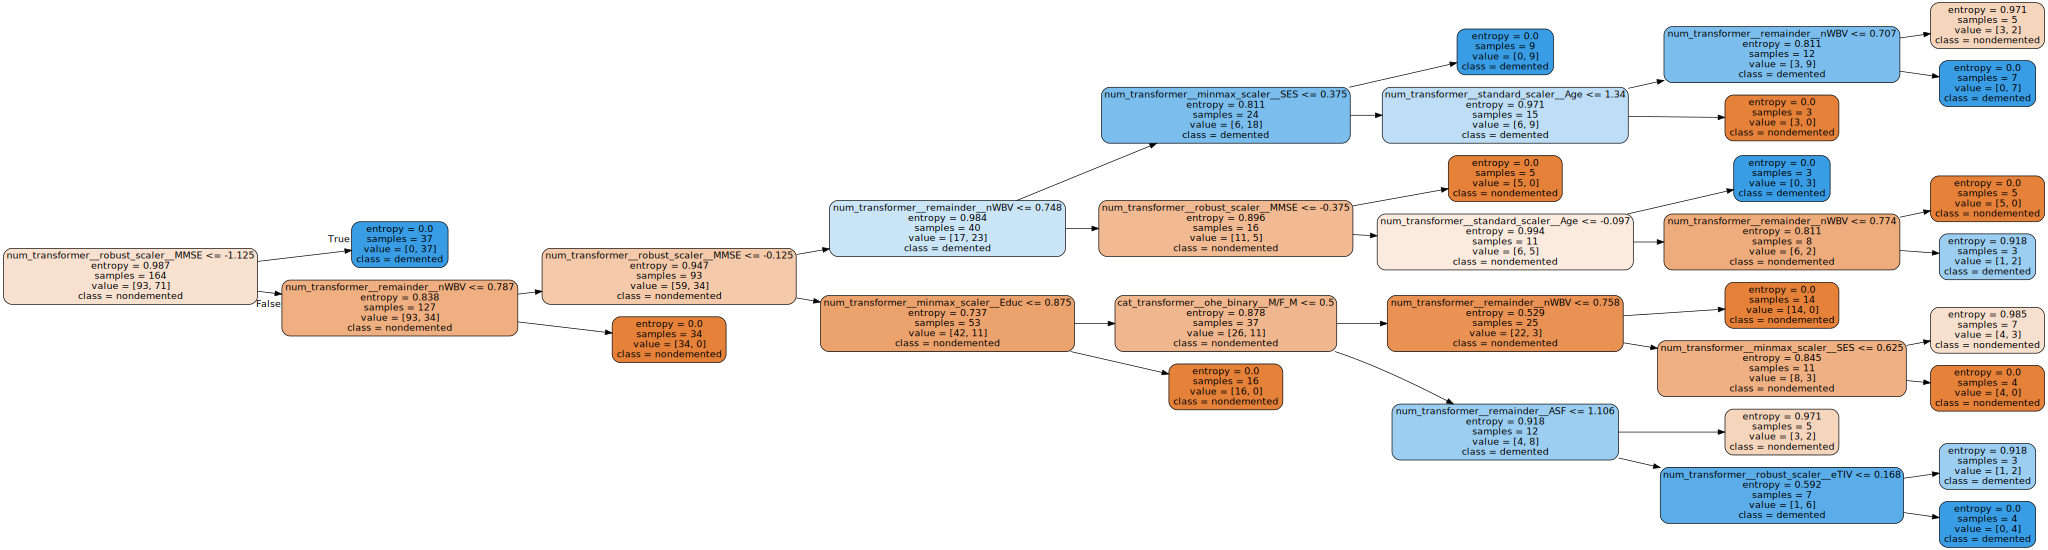

In [77]:
# Export model graph
export_graphviz(best_tree, out_file="best_tree.dot", 
                feature_names=X_train_trial.columns,
                class_names=['nondemented', 'demented'], 
                rounded=True,
                filled=True,
                rotate = True,
                fontname = 'futura')

# Import model graph
with open("best_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

<big> Conclusion: </big>

y_train = 76 demented, 100 nondemented

y_pred = 61 demented, 115 nondemented

## Random Forest

### Grid Searching

In [78]:
# CREATING  RANDOM GRID
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [79]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 5, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Best Forest

In [80]:
# Defining best estimator for random forest
best_rf = rf_random.best_estimator_

# Fitting best random forest
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=10,
                       n_estimators=1000)

# XGBoost

- Sequential method
- Reduce bias
- Best weak learners given more weight

In [81]:
# Instantiating classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
recall_score(y_test, preds)

/home/cynthias13w/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/cynthias13w/.pyenv/versions/3.8.12/envs/memobrain/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:24:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7241379310344828

### Grid Searching

In [82]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [83]:
grid_cv = GridSearchCV(xgb_cl, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=3, 
                       scoring="recall")

In [84]:
best_xgb = grid_cv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
best_xgb.fit(X_train, y_train)

In [ ]:
# Predict
best_xgb_pred = best_xgb.predict(X_test)

# Score
recall_score(y_test, best_xgb_pred)

# Exporting Data

In [ ]:
frames=[X_scaled, y]
frames

In [ ]:
preprocessed_oasis1 = pd.concat(frames, axis =1)

In [ ]:
#preprocessed_oasis1.to_csv(r'~/code/mkvph0ch/memobrain/notebooks/preprocessed_oasis1.csv')

# Recall Scores

<big> <b> Model names </b> </big>

<big> <font color = 'steelblue'> SVC </color> </big>

Linear: best_linear_svc - 78.2


Polynomial: best_poly_svc - 69.6 
    

Rbf: best_rbf_svc - 82.6  


<big> <font color = 'steelblue'> K Neighbors Classifier </color> <big>

best_neigh - 65.0

<big> <font color = 'steelblue'> Decision Tree </color> </big>
    
best_tree - 78.3


# Evaluating OASIS2

## Importing Data

In [ ]:
oasis2_cs_path = '../raw_data/OASIS2/preprocessed_oasis2.csv'
oasis2 = pd.read_csv(oasis2_cs_path)

In [ ]:
oasis2

In [ ]:
X2 = oasis2.drop(columns = 'CDR')
y2 = oasis2['CDR']

In [ ]:
X_train2, X_test2, ytrain2, y_test2 = train_test_split(X2, y2, test_size=0.30, random_state=42)

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.4s
[CV] END bootstrap=True, max_depth=7

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   3.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   4.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   5.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   2.9s
[CV] END bootstrap=False, max_depth=70

## Evaluating